***
<div style="text-align: right">
Latest update: 2020-07-26
</div>

<p style="font-size:30px; color:blue;">
Density Estimation using Markov Chains <br><br>
</p>

<div style="text-align: right"><div style="font-style: italic">
Andrea De Simone<br>
Alessandro Morandini<br>
</div>
<br>please cite: arXiv:20XX.XXXX
</div>

***


In [1]:
#import the estimator class and some other modules
from MCDE import MCDensityEstimator

import numpy as np
import scipy
import math
import random

%matplotlib inline

### 1D example

In [2]:
# Generate a sample of 300 points from a bimodal (sum of two normal distributions)
N_points=300
rv1 = scipy.stats.norm(1,1)
rv2 = scipy.stats.norm(8,2)

Xa=rv1.rvs(size=int(N_points/2), random_state=4)
Xb=rv2.rvs(size=int(N_points/2), random_state=2)
X=np.hstack([Xa,Xb])

In [3]:
# optimization step
loss=[]
bw_range=np.linspace(0.2,1,9)
for bw in bw_range:
    DE = MCDensityEstimator(bw=bw, interpolation_method='linear', weight_func='gaussian')
    DE.fit(X)
    loss.append(-np.sum(np.log(DE.pdf)))
loss=np.array(loss)
opt_bw=bw_range[np.argmin(loss)]
print('The optimal bandwidth is '+str(opt_bw))

The optimal bandwidth is 0.5


In [4]:
# Here we estimate the underlying PDF, bw has been found at the previous point
DE = MCDensityEstimator(bw=0.5, interpolation_method='linear')
DE.fit(X)

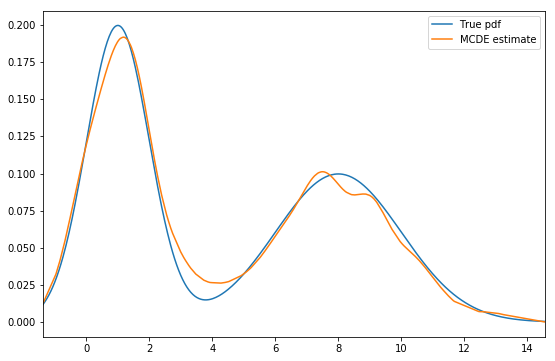

In [5]:
import matplotlib.pyplot as plt

x = np.linspace(X.min(),X.max(),500)
est = DE.evaluate_pdf(x)
true=0.5*rv1.pdf(x)+0.5*rv2.pdf(x)

fig, axs = plt.subplots(figsize=(9, 6))

plt.plot(x, true, label='True pdf')
plt.plot(x, est, label='MCDE estimate')
plt.xlim([X.min(),X.max()])
plt.legend()

plt.show()

### 2D example

In [6]:
# Generate a sample of 1000 points from the sum of two 2D gaussians with non-diagonal covariance
N_points=1000
rv1 = scipy.stats.multivariate_normal(mean=[3,8], cov=[[1,-1.5],[-1.5,4]])
rv2 = scipy.stats.multivariate_normal(mean=[8,3], cov=[[4,1.5],[1.5,1]]) 

Xa=rv1.rvs(size=int(N_points/2), random_state=1)
Xb=rv2.rvs(size=int(N_points/2), random_state=2)
X=np.vstack([Xa,Xb])

# Here we estimate the underlying PDF, bw has been fixed by us for this problem
DE = MCDensityEstimator(bw=0.3, interpolation_method='linear')
DE.fit(X)

In [7]:
# the estimate has been obtained, if we want to look at marginal distributions
# we need to perform some integrations along x and y

import mcint

# define the sampler and the volume necessary to integrate
def sampler(X, a, axis):
    while True:
        r = random.uniform(X.min(),X.max())
        if axis=='x':
            gen_list=[r,a]
        elif axis=='y':
            gen_list=[a,r]
        yield (gen_list)

def volume( X ):
    vol = ( X.max() - X.min() )
    return( vol )

# this is the true marginal along both x and y
def marginal(x):
    return 0.5*6.7*1e-5*np.exp(2*x-0.125*x**2)+0.5*4.4e-3*np.exp(3*x-0.5*x**2)

# in the following we make our marginal estimate, a priori different along x and y
x=np.linspace(0,14,56)
margx=[]
margy=[]

for point in x:
    integral, _ = mcint.integrate(DE.evaluate_pdf,
                                                sampler(X,point,'y'),
                                                measure=volume(X),
                                                n=5000)
    margx.append(integral)
    integral, _ = mcint.integrate(DE.evaluate_pdf,
                                                sampler(X,point,'x'),
                                                measure=volume(X),
                                                n=5000)
    margy.append(integral)

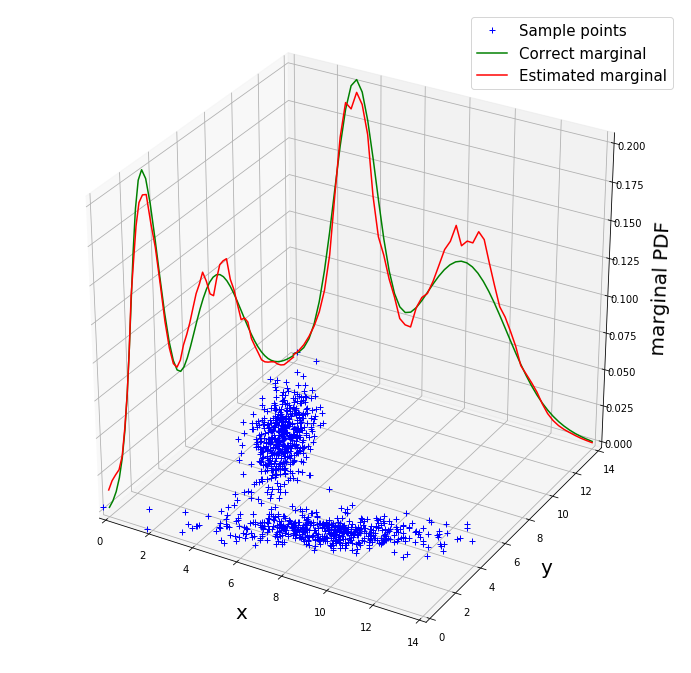

In [8]:
# here we plot the true marginal distributions
# to be compared with our estimates
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig= plt.figure(figsize=(12,12))
ax= fig.add_subplot(111, projection= '3d')

ax.plot(X[:,0],X[:,1],'b+',zdir='z',zs=0, label='Sample points')
ax.plot(x, marginal(x), 'g', zdir='x', zs=0, label='Correct marginal')
ax.plot(x, margx, 'r', zdir='x', zs=0, label='Estimated marginal')
ax.plot(x, marginal(x), 'g', zdir='y', zs=14)
ax.plot(x, margy, 'r', zdir='y', zs=14)

ax.set_xlabel('x', fontsize=20, labelpad=10)
ax.set_ylabel('y', fontsize=20, labelpad=10)
ax.set_zlabel('marginal PDF', fontsize=20, labelpad=16)
ax.set_xlim([x.min(), x.max()])
ax.set_ylim([x.min(), x.max()])

plt.legend(fontsize=15)
plt.show()